In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd '/content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project'
%ls
import os
path = os.getcwd()
print('path: ' + path)
OutputPath = path + '/Output'
ModelPath = path + '/Models'
DataPath = path + '/Data'

/content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project
 Chat_GPT_rating_accuracy.ipynb   GPT2_prediction.ipynb   Output/
 CNN_rating_prediction.ipynb      LLaVa_Inference.ipynb   Prediction_with_CLIP.ipynb
 Data/                            Models/                'Score comparision.ipynb'
path: /content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project


In [12]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, accuracy_score, cohen_kappa_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

In [13]:
# Paths to data files
files = {
    'CLIP_pred': os.path.join(OutputPath, 'clip_predictions_text_images_with_actual_ratings.csv'),
    'BERT_pred_images': os.path.join(OutputPath, 'bert_predictions_images.csv'),
    'CNN_pred': os.path.join(OutputPath, 'CNN_pred.csv'),
    'LLavA_image_based_ratings': os.path.join(OutputPath, 'image_based_ratings.csv'),
    'LLavA_combined_ratings': os.path.join(OutputPath, 'combined_ratings.csv'),
    'ChatGPT4_scores': os.path.join(OutputPath, 'chatgpt_vs_actual_scores.csv')
}


In [14]:
# Function to calculate Quadratic Weighted Kappa (QWK)
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

# Function to calculate Prediction Diversity Score (Entropy-based)
def prediction_diversity_score(y_pred):
    unique, counts = np.unique(y_pred, return_counts=True)
    probabilities = counts / len(y_pred)
    entropy = stats.entropy(probabilities, base=2)  # Entropy calculation
    normalized_entropy = entropy / np.log2(len(unique))  # Normalize by maximum entropy
    return normalized_entropy

# Function to calculate Root Mean Squared Error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate all metrics for a single prediction file
def calculate_metrics(df, true_col, pred_col, model_name):
    y_true = df[true_col]
    y_pred = df[pred_col]

    mae = mean_absolute_error(y_true, y_pred)
    qwk = quadratic_weighted_kappa(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    diversity_score = prediction_diversity_score(y_pred)
    root_mse = rmse(y_true, y_pred)

    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': root_mse,
        'QWK': qwk,
        'Accuracy': accuracy,
        'Diversity Score': diversity_score
    }

In [15]:
# Define column mapping for each file
file_column_mappings = {
    'CLIP_pred': {'true_col': 'rating', 'pred_col': 'predicted_rating'},
    'BERT_pred_images': {'true_col': 'rating', 'pred_col': 'predicted_score'},
    'CNN_pred': {'true_col': 'true_rating', 'pred_col': 'predicted_rating'},
    'LLavA_image_based_ratings': {'true_col': 'actual_rating', 'pred_col': 'predicted_rating'},
    'LLavA_combined_ratings': {'true_col': 'actual_rating', 'pred_col': 'predicted_rating'},
    'ChatGPT4_scores': {'true_col': 'rating', 'pred_col': 'chatgpt_rating'}


}

# Initialize a list to store metric results
metrics_list = []

# Process each file
for model_name, file_path in files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        columns = file_column_mappings[model_name]
        metrics = calculate_metrics(df, true_col=columns['true_col'], pred_col=columns['pred_col'], model_name=model_name)
        metrics_list.append(metrics)
    else:
        print(f"File not found: {file_path}")

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_list)
metrics_output_file = os.path.join(OutputPath, 'model_comparison_metrics.csv')
metrics_df.to_csv(metrics_output_file, index=False)

# Print comparison table
print("Model Comparison Metrics:")
print(metrics_df)

Model Comparison Metrics:
                       Model       MAE      RMSE       QWK  Accuracy  \
0                  CLIP_pred  2.942424  3.188521  0.000000  0.063636   
1           BERT_pred_images  1.057576  1.620886  0.000000  0.451515   
2                   CNN_pred  1.166667  1.581139 -0.077151  0.333333   
3  LLavA_image_based_ratings  1.060606  1.341641 -0.015827  0.233333   
4     LLavA_combined_ratings  0.806061  1.114641  0.410530  0.318182   
5            ChatGPT4_scores  1.115016  1.404011 -0.008449  0.239617   

   Diversity Score  
0              NaN  
1              NaN  
2         0.796330  
3         0.377931  
4         0.438496  
5         0.730407  


<ipython-input-14-f1b0c8bbb4ea>:10: RuntimeWarning: invalid value encountered in scalar divide
  normalized_entropy = entropy / np.log2(len(unique))  # Normalize by maximum entropy
<ipython-input-14-f1b0c8bbb4ea>:10: RuntimeWarning: invalid value encountered in scalar divide
  normalized_entropy = entropy / np.log2(len(unique))  # Normalize by maximum entropy


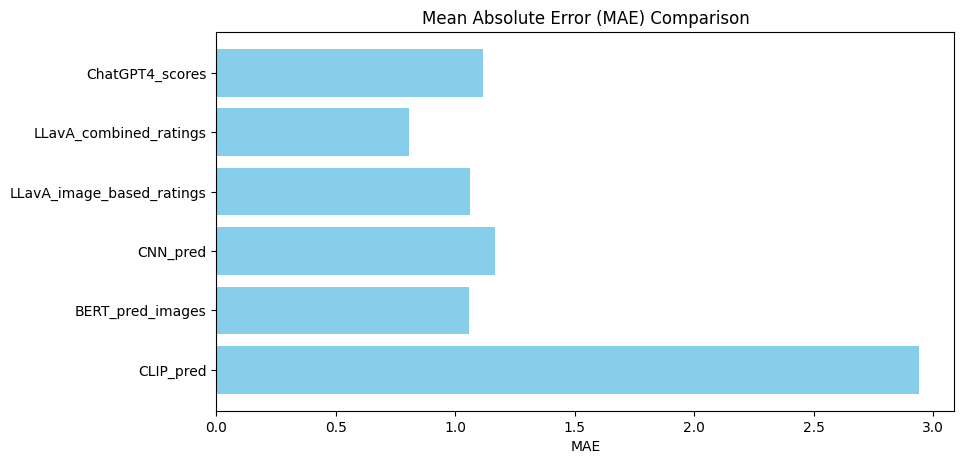

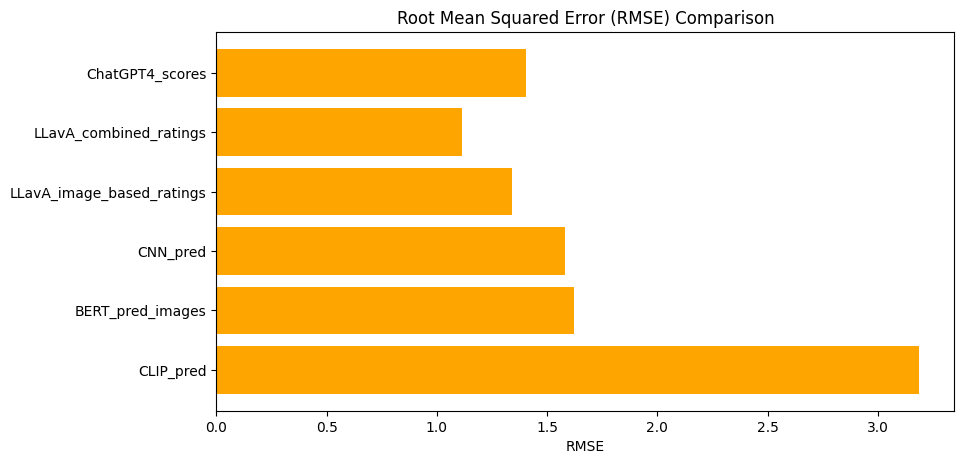

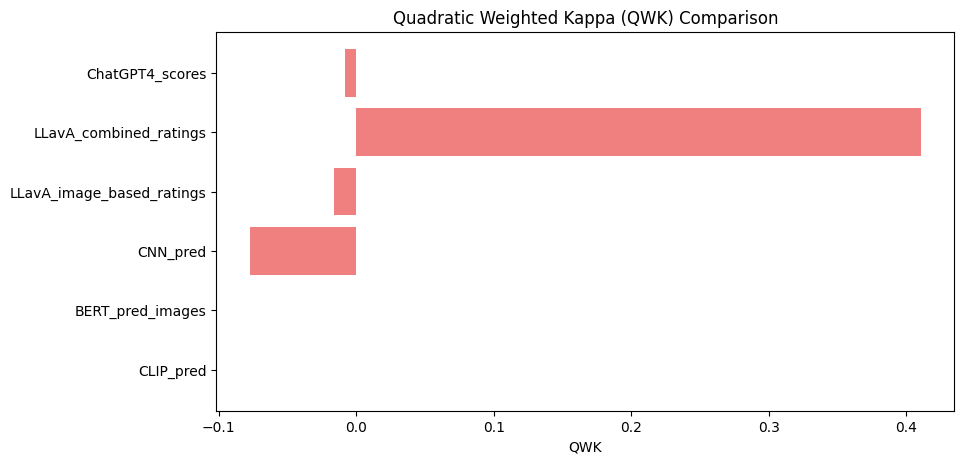

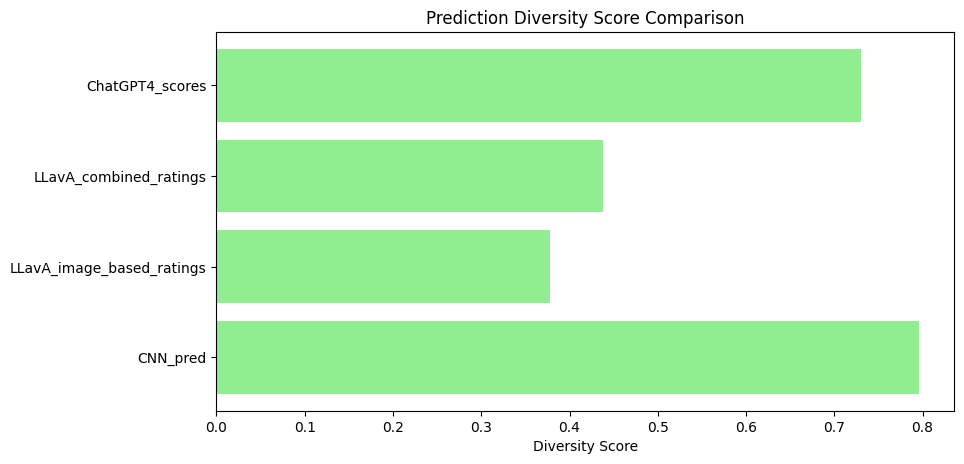

In [16]:
# Plot MAE
plt.figure(figsize=(10, 5))
plt.barh(metrics_df['Model'], metrics_df['MAE'], color='skyblue')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('MAE')
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(OutputPath, 'mae_comparison.png'))
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.barh(metrics_df['Model'], metrics_df['RMSE'], color='orange')
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.xlabel('RMSE')
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(OutputPath, 'rmse_comparison.png'))
plt.show()

# Plot QWK
plt.figure(figsize=(10, 5))
plt.barh(metrics_df['Model'], metrics_df['QWK'], color='lightcoral')
plt.title('Quadratic Weighted Kappa (QWK) Comparison')
plt.xlabel('QWK')
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(OutputPath, 'qwk_comparison.png'))
plt.show()

# Plot Prediction Diversity Score
plt.figure(figsize=(10, 5))
plt.barh(metrics_df['Model'], metrics_df['Diversity Score'], color='lightgreen')
plt.title('Prediction Diversity Score Comparison')
plt.xlabel('Diversity Score')
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(OutputPath, 'diversity_score_comparison.png'))
plt.show()

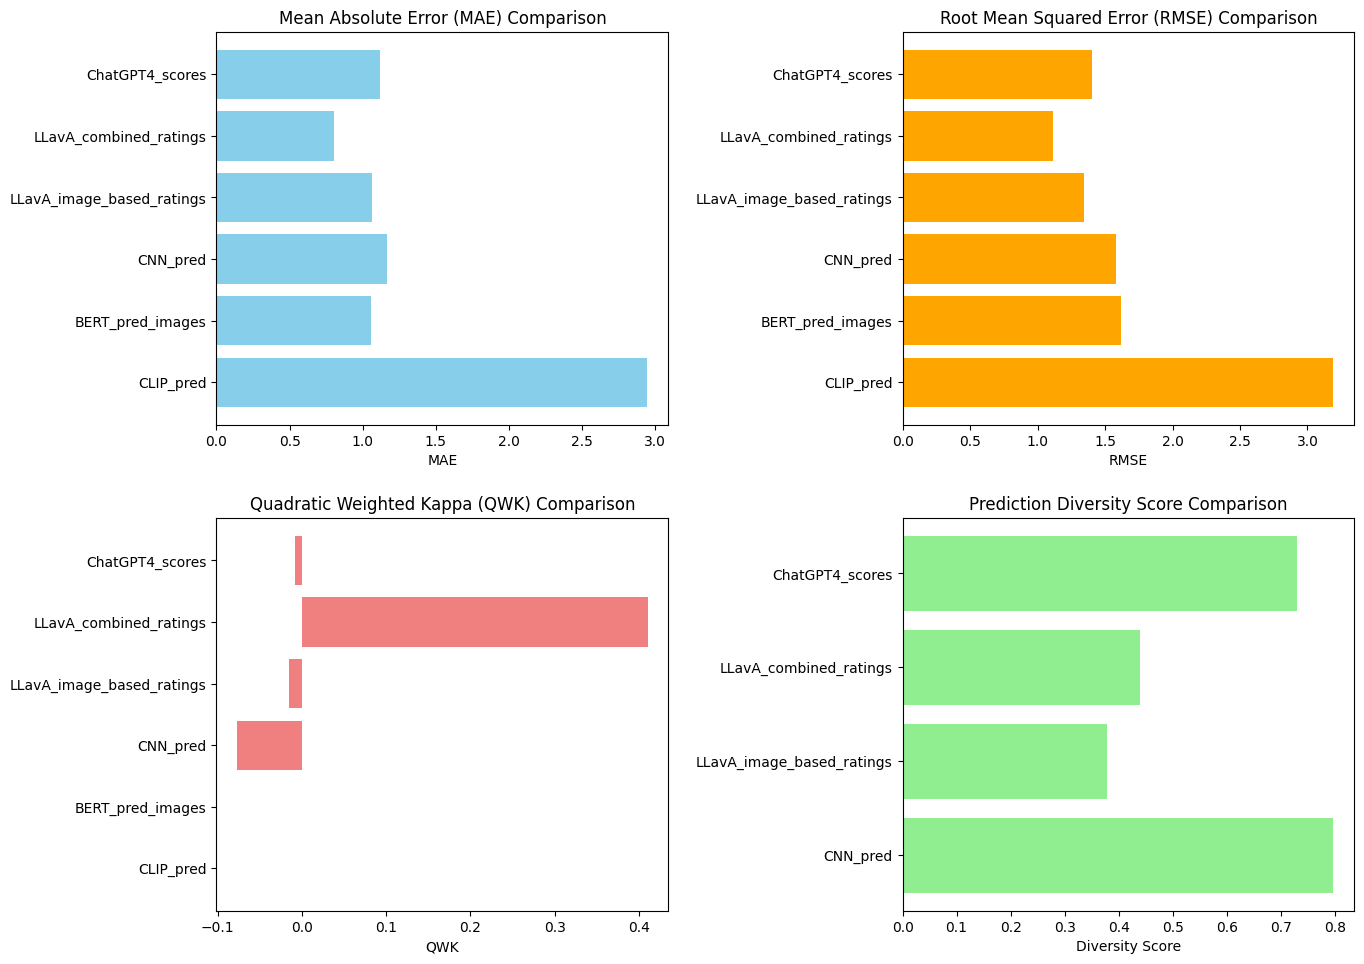

In [18]:

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot MAE
axs[0, 0].barh(metrics_df['Model'], metrics_df['MAE'], color='skyblue')
axs[0, 0].set_title('Mean Absolute Error (MAE) Comparison')
axs[0, 0].set_xlabel('MAE')

# Plot RMSE
axs[0, 1].barh(metrics_df['Model'], metrics_df['RMSE'], color='orange')
axs[0, 1].set_title('Root Mean Squared Error (RMSE) Comparison')
axs[0, 1].set_xlabel('RMSE')

# Plot QWK
axs[1, 0].barh(metrics_df['Model'], metrics_df['QWK'], color='lightcoral')
axs[1, 0].set_title('Quadratic Weighted Kappa (QWK) Comparison')
axs[1, 0].set_xlabel('QWK')

# Plot Prediction Diversity Score
axs[1, 1].barh(metrics_df['Model'], metrics_df['Diversity Score'], color='lightgreen')
axs[1, 1].set_title('Prediction Diversity Score Comparison')
axs[1, 1].set_xlabel('Diversity Score')

# Adjust layout and save the entire figure as a single image
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(OutputPath, 'model_comparison_metrics.png'))

# Show the plot
plt.show()
